## Введение в компьютерное зрение (CV): калибровка камеры

Эта домашка была построена на базе туториала OpenCV: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

Что почитать:
* Конушин А. Геометрические свойства нескольких изображений: https://masters.donntu.ru/2020/etf/azin/library/article4.htm
* Примеры дисторсии и дугих искажений: https://help.autodesk.com/view/ARNOL/ENU/?guid=arnold_user_guide_ac_cameras_ac_perspective_camera_html

![img](https://help.autodesk.com/cloudhelp/ENU/AR-Core/images/ac-perspective-camera-radial-distortion-man-2-3.gif)
![img](https://upload.wikimedia.org/wikipedia/commons/d/d3/Camera_focal_length_distance_house_animation.gif)

Любая камера, которая используется для работы не идеальна. Матрица смещена относительно центра линзы, линза кривая, FOV настолько большой, что у людей на катринках носы больше головы. Чтобы компенсировать искажения, людьми были придуманы некоторые алгоритмы. Но сначала теория:

### 1. Немного теории
Презентации: 
* (стр. 1-10) http://www.myshared.ru/slide/1351161/
* https://3d.bk.tudelft.nl/courses/geo1016/slides/Lecture_03_Calibration.pdf

Радиальная дисторсия be like:

![distortion](https://docs.opencv.org/4.x/distortion_examples.png)

Для лучшего понимания математического описания дисторсии стоит прочиать [basics из туториала OpenCV](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html).

Примеры калибровочных шаблонов:

![templates](https://www.researchgate.net/profile/Andrew-Hieu-Nguyen/publication/323782425/figure/fig3/AS:1112642001350662@1642285933669/Example-of-four-commonly-used-camera-calibration-targets.png)

### 2. Практика


1) Теоретическая задачка на разогрев. Определите параметры (диапазон значений) матрицы внутренней калибровки для камеры Panasonic DMC-FZ20 (**1 point**):

https://www.dpreview.com/products/panasonic/compacts/panasonic_dmcfz20/specifications


$$\mathbf{K} =  \left[\begin{array}{cc} f_{x} & s & c_{x} \\  & f_{y} & c_{y} \\  &   & 1 \end{array}\right]$$



Sensor size: $1/2.5$" $(5.744 $ x $ 4.308 mm)$
$$ c_{x},\space c_{y} =  2.872,\space  2.154 \space mm$$

Normal focus range: $ f = 30$ cm
$$ f_{x} = \frac{f}{p_{x}} {;}\space\space f_{y} = \frac{f}{p_{y}}$$

$$ p_{x} = 1.65 * 10^{-9} \space\space\space p_{y} = 1.236 * 10^{-9} $$

$$s = 0$$

$$\mathbf{K} =  \left[\begin{array}{cc} \frac{30}{1.65e-9} & 0 & 2.872 
                                \\  & \frac{30}{1.236e-9} & 2.154
                                \\  &   & 1 \end{array}\right]$$


In [1]:
# %pip install matplotlib==3.8.2 numpy==1.26.3 opencv-python==4.7.0.68

Ниже ячейка, где вы можете сфотографировать свои шаблоны (`patterns/pattern.png`). Фото делается по пробелу, выход из программы - escape. Фотографии сохраняются в папку `images/`

In [2]:
# import take_photos

# take_photos.main(0) # Input: number of camera

Найдем углы квадратов шаблона:

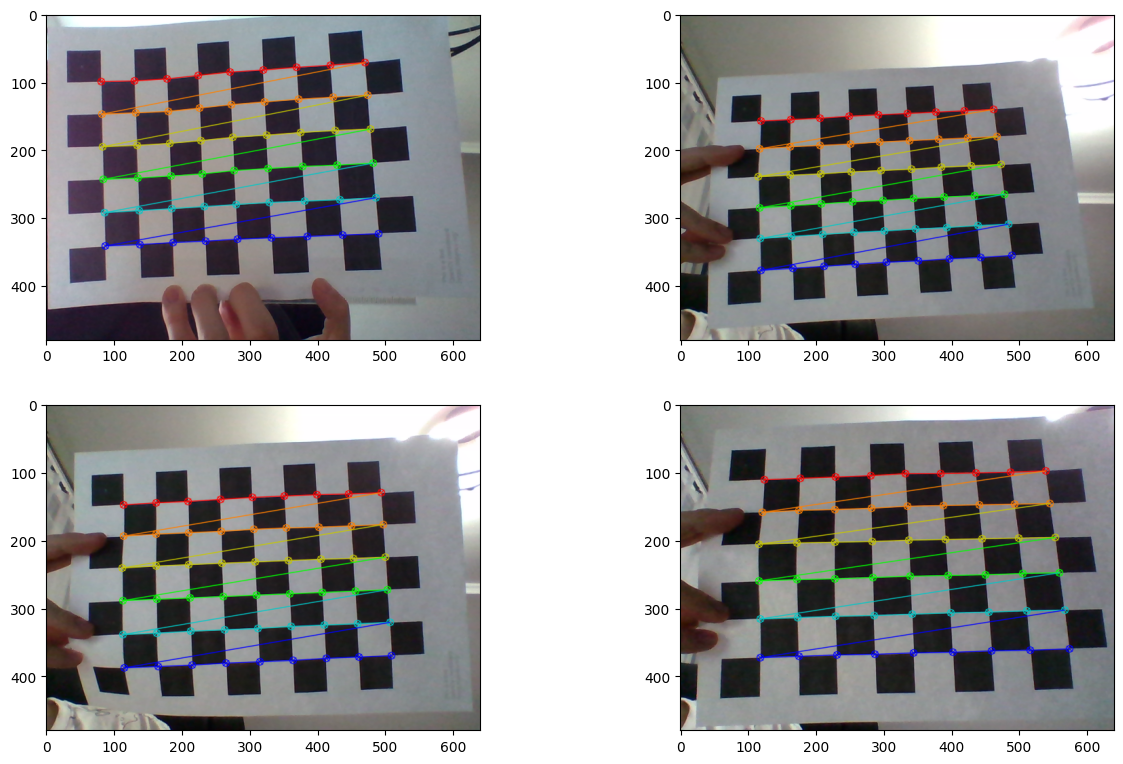

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import glob
import os

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((9*6, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('images/*.png')

plt.figure(figsize=(15, 60))

for i, fname in enumerate(images):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (9, 6), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, (9, 6), corners2, ret)

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.subplot(int(np.ceil(len(images) * 3)), 2, i + 1)
    plt.imshow(img)

plt.show()

Получаем матрицу камеры, коэффициенты дисторсии, векторы поворотов и положений камеры:

In [4]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx, dist, rvecs, tvecs, sep='\n\n')

[[807.44963352   0.         332.6095626 ]
 [  0.         803.5606072  243.84660554]
 [  0.           0.           1.        ]]

[[-0.20438696  0.32894814  0.01896089  0.01603802 12.09249218]]

(array([[-0.0614385 ],
       [ 0.07455071],
       [-0.05669099]]), array([[-0.24489734],
       [-0.07511377],
       [-0.06125967]]), array([[-0.08750941],
       [-0.05594997],
       [-0.04369984]]), array([[-0.25401137],
       [-0.05482064],
       [-0.03746224]]))

(array([[-5.23562946],
       [-3.02174446],
       [16.5150722 ]]), array([[-4.93652998],
       [-2.03751803],
       [18.13520544]]), array([[-4.59854662],
       [-2.07303291],
       [16.48319858]]), array([[-4.0022634 ],
       [-2.60513175],
       [15.02830031]]))


2) Прокомментируйте полученные значения матрицы внутренней калибровки. Какие физические параметры камеры можно сказать, а какие нельзя? (**1 point**)

1) Матрица камеры: $f_{x} = 807.45$, $s = 0$, $c_{x} = 332.6$, $f_{y} = 803.56$, $c_{y} = 243.85$

Нельзя определить $f = f_{x}*p_{x}$ или $f = f_{y}*p_{y}$, где размеры пикселей $p_{x/y}$ неизвестны
 
2) Вектор, хранящий значения коэффициентов дисторсии для слагаемых разных порядков. 

Их величины зависят от:
* расстояния до предмета
* длин волн света (вики) 

3) Векторы поворота и положений.

Например, из векторов положений для 1 и 2 фото

$array([[-5.23562946], [-3.02174446], [16.5150722]]),$  
$array([[-4.93652998], [-2.03751803], [18.13520544]])$

видно смещение по оси Z, которое легко проверить: на 2-м фото изображение смещено вниз, что эквивалентно движению камеры вверх


А что там с дисторсией?

![dist](https://arnold-rendering.com/wp-content/uploads/2017/06/radial_distortion_face_user-guide.gif?w=600)

Уточним матрицу камеры:

In [5]:
img = cv.imread('images/img1.png')
h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
print(newcameramtx, roi, sep='\n\n')

[[821.11004639   0.         334.65258186]
 [  0.         794.97271729 247.30052261]
 [  0.           0.           1.        ]]

(25, 25, 595, 432)


Избавимся от дисторсии и нарисуем, что получилось:

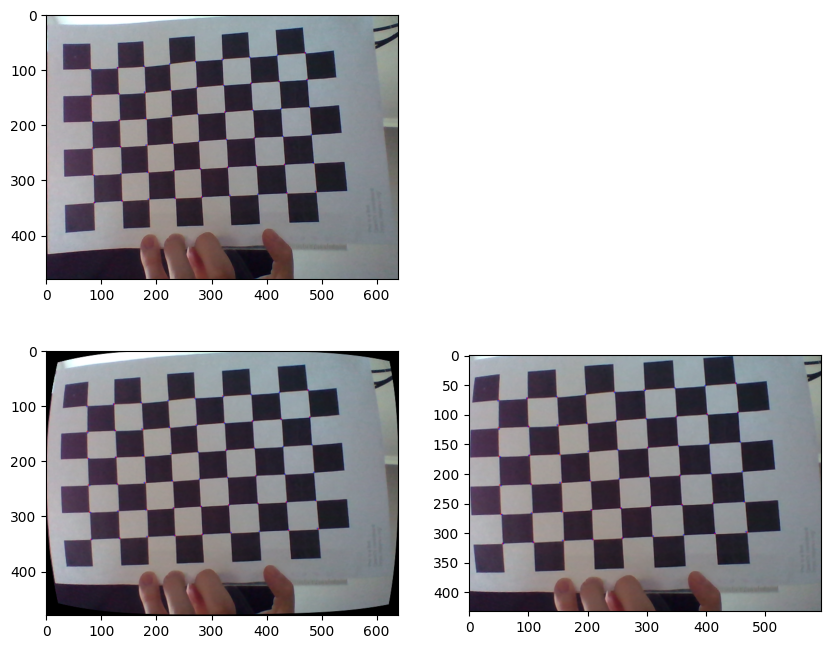

In [12]:
# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x, y, w, h = roi
cropped = dst[y:y+h, x:x+w]

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
dst = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
cropped = cv.cvtColor(cropped, cv.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(img)
plt.subplot(2, 2, 3)
plt.imshow(dst)
plt.subplot(2, 2, 4)
plt.imshow(cropped)
plt.show()

Еще примеры:

![before](https://i.stack.imgur.com/xNc5k.jpg)
![after](https://i.stack.imgur.com/O9osX.jpg)

Посчитаем ошибку репроекции:

In [7]:
mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2) / len(imgpoints2)
    mean_error += error

total_error = mean_error / len(objpoints)
print( "total error: {}".format(total_error))

total error: 0.15683382929724457


Честно, значение total_error < 0.2 получилось изначально - видимо, камера уже хорошо откалибрована.

У меня где-то завалялась внешняя веб-камера, у которой точно наблюдались признаки дисторсии, но не могу проверить это сейчас.

3) За ошибку репроекции < 0.2 дается **1 point**

In [8]:
assert total_error < 0.2

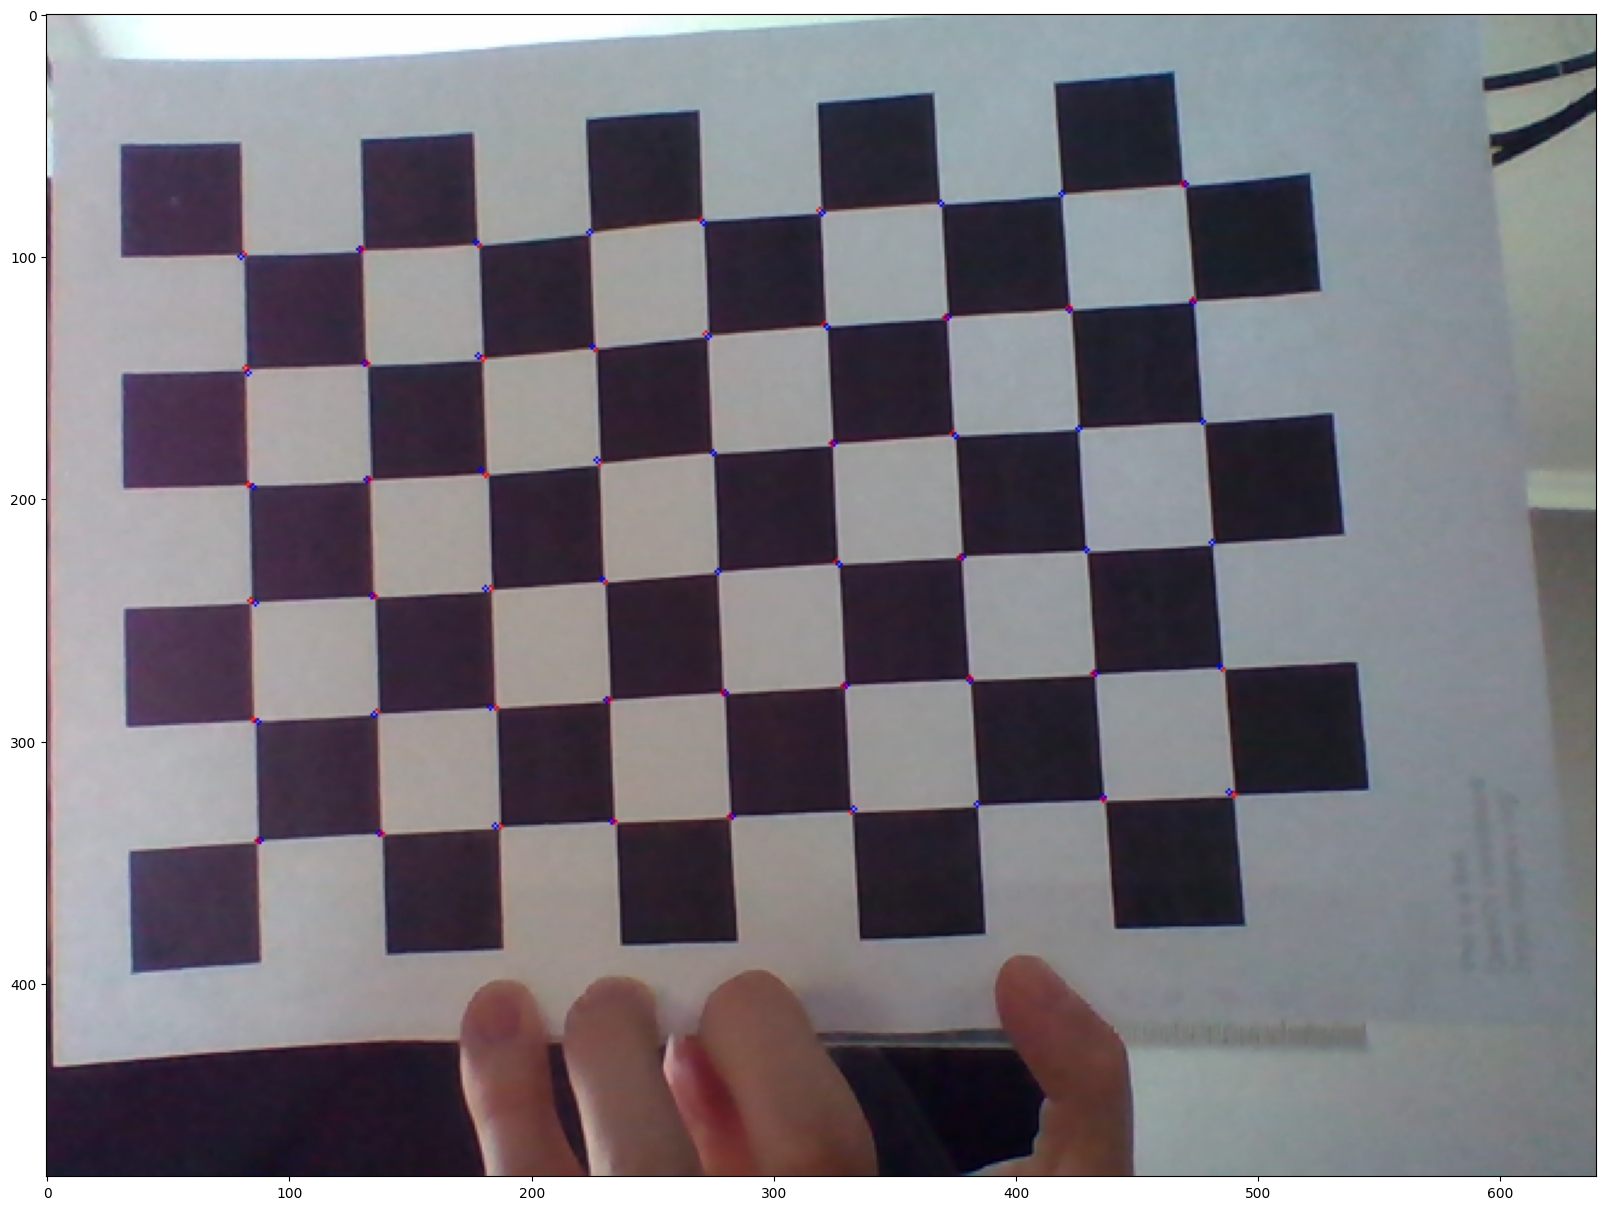

In [9]:
img_index = 0

img = cv.imread(images[img_index])

imgpoints2, _ = cv.projectPoints(objpoints[img_index], rvecs[img_index], tvecs[img_index], mtx, dist)
cur_imgpoints = np.array(imgpoints[img_index])

for i in range(imgpoints2.shape[0]):
    img = cv.circle(img, cur_imgpoints[i, 0].astype('int'), 1, (0, 0, 255), 1)
    img = cv.circle(img, imgpoints2[i, 0].astype('int'), 1, (255, 0, 0), 1)

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.figure(figsize=(20, 40))
plt.imshow(img)
plt.show()

4) Определите размер ячейки шахматной доски, листа А4 или любого другого объекта, если знаете расстояние до него. Сделайте замер расстояния при фотографировании (**2 points**)

In [39]:
# TODO
# img1 --- 28 centimeters
points = []

for point in imgpoints2:
    p = np.array([[point[0][0]], [point[0][1]], [1]])
    # print(P, sep = '\n')
    points.append(mtx @ p)

# print(*points, sep = '\n')

measured_distance = 28  # cm
focal_length = 40       # cm
width_in_rf_image = (points[2][0] - points[1][0]) / 10**4   # cm

real_width = (width_in_rf_image* measured_distance)/ focal_length   # cm

print(*real_width, 'cm\nReal width - 2.5 cm')

2.6672467875011776 cm
Real width - 2.5 cm


### Extra задание: сделайте калибровку камеры по шаблону с кругами (**2 points**)

В этом поможет: `cv2.findСirclesGrid` [[link]](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gac8fb88c7652a7699743aeb6073ef9b4a). Так же вы можете пользоваться и другими библиотеками, например [skimage](https://scikit-image.org/).

Паттерн калибровки лежит в `patterns/circles_pattern.jpg`